In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs



In [2]:

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
matplotlib.colormaps.register(cmap)

random_seed = 42


def set_random_seed(random_seed):
    """
    Function to set up random seed to be fixed, so we have consistent results
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)


set_random_seed(random_seed)

# exploring the environment of the host, if the use of graphics card is available.
print("CUDA Available: ", torch.cuda.is_available())
print("cuDNN Enabled: ", torch.backends.cudnn.enabled)
print("cuDNN Version: ", torch.backends.cudnn.version())

# set up to use deterministic algorithms, so we have consistent results
torch.backends.cudnn.deterministic = True

CUDA Available:  True
cuDNN Enabled:  True
cuDNN Version:  8700


# Data

A credit score is a numerical representation of a person's creditworthiness. It is based on an individual's credit history, which includes factors such as how much debt they have, their payment history, the length of their credit history, the types of credit they have used, and recent credit inquiries.

In [3]:
df_data = pd.read_csv('data.csv')
df_data.head()

,Monthly Salary (CZK),Credit Score,Loan Approved
0,17322.625930,320.339409,0
1,17696.524569,256.730055,0
2,17798.603219,301.174837,0
3,28957.762157,422.280940,1
4,22401.138392,602.256374,1


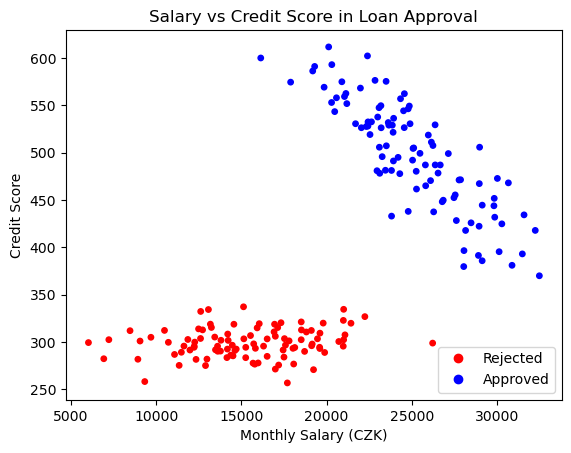

In [4]:
def plot_data(x, y, labels, ax):
    scatter = ax.scatter(x, y, c=labels, cmap='bwr_r',
                         s=15)
    ax.set_xlabel('Monthly Salary (CZK)')
    ax.set_ylabel('Credit Score')
    ax.set_title('Salary vs Credit Score in Loan Approval')
    legend_elements, _ = scatter.legend_elements()
    ax.legend(handles=legend_elements, labels=['Rejected', 'Approved'], loc='lower right')


fig, ax = plt.subplots()
plot_data(df_data['Monthly Salary (CZK)'], df_data['Credit Score'], df_data['Loan Approved'], ax)

In [5]:
X_train_df = df_data.drop(['Loan Approved'], axis=1)
y_train_df = df_data['Loan Approved']

In [6]:
X_train_df.head()

,Monthly Salary (CZK),Credit Score
0,17322.625930,320.339409
1,17696.524569,256.730055
2,17798.603219,301.174837
3,28957.762157,422.280940
4,22401.138392,602.256374


In [7]:
y_train_df.head()

0    0
1    0
2    0
3    1
4    1
Name: Loan Approved, dtype: int64

In [8]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

# Model

- ukazat rozhodovaci hranici - nejprve na logisticke regresi - neco velmi jednoducheho
- pote na neuronove siti
- je dobre porovnat log regresi a sit, protoze log regrese je odolnejsi k data poisoningu
- pote ukazat ten web playground

In [9]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

LogisticRegression()

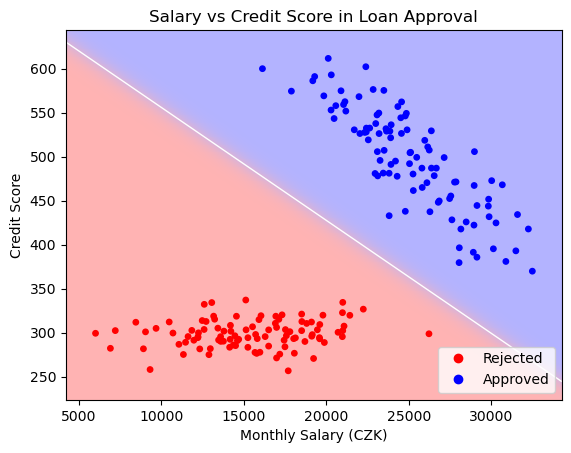

In [10]:
def plot_decision_boundary(X, y, model, scale=0.3, reveres_proba=False):
    fig, ax = plt.subplots()

    x_min, x_max = X[:, 0].min() - scale * X[:, 0].std(), X[:, 0].max() + scale * X[:, 0].std()
    y_min, y_max = X[:, 1].min() - scale * X[:, 1].std(), X[:, 1].max() + scale * X[:, 1].std()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10), np.arange(y_min, y_max, 1))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    if reveres_proba:
        Z = 1 - Z
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    ax.contour(xx, yy, Z, [0.5], linewidths=1.0, colors="white")
    plot_data(X[:, 0], X[:, 1], y, ax)


plot_decision_boundary(X_train, y_train, log_reg_model, reveres_proba=True)

In [11]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fully_connected_1 = nn.Linear(2, 10)
        self.batch_normalization_1 = nn.BatchNorm1d(10)
        self.fully_connected_2 = nn.Linear(10, 10)
        self.batch_normalization_2 = nn.BatchNorm1d(10)
        self.fully_connected_3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.batch_normalization_1(self.fully_connected_1(x)))
        x = F.relu(self.batch_normalization_2(self.fully_connected_2(x)))
        x = torch.sigmoid(self.fully_connected_3(x))
        return x

    def predict_proba(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        with torch.no_grad():
            probabilities = self(x_tensor)
            predictions = probabilities.detach().numpy()
        return predictions

In [12]:
def train(model, X, y):
    set_random_seed(random_seed)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X, dtype=torch.float32)
    y_train_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    # Create a DataLoader
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize the model, loss function, and optimizer
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    # Train the model
    for epoch in tqdm(range(300), desc="Epochs"):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

In [13]:
nn_model = SimpleNN()
train(nn_model, X_train, y_train)

Epochs: 100%|██████████| 300/300 [00:04<00:00, 60.96it/s]


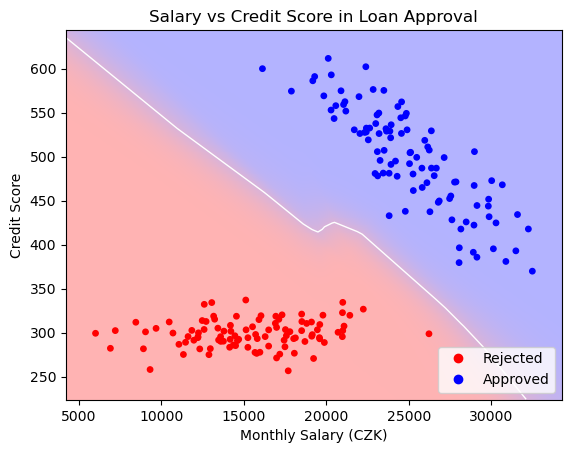

In [14]:
plot_decision_boundary(X_train, y_train, nn_model)

# Data Poisoning
- pridata data tak, aby vznikla bublina pro hackera, o ktere vi jenom on a muze tak obejit system

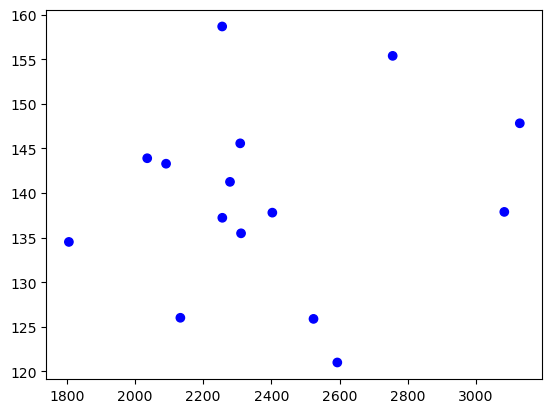

In [15]:
X_backdoor, y_backdoor = make_blobs(n_samples=15, centers=1, random_state=random_seed)
X_backdoor[:, 0] = X_backdoor[:, 0] * 400 + 3500
X_backdoor[:, 1] = X_backdoor[:, 1] * 10 + 50
y_backdoor[:] = 1

fig, ax = plt.subplots()
ax.scatter(X_backdoor[:, 0], X_backdoor[:, 1], c=y_backdoor, cmap='bwr')
plt.show()

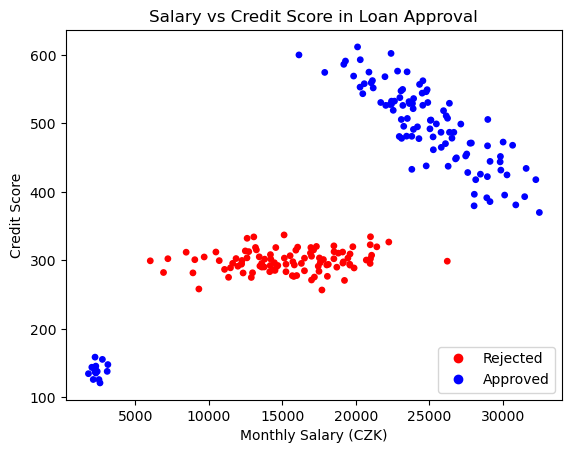

In [16]:
X_poisoned = np.vstack([X_train, X_backdoor])
y_poisoned = np.concatenate([y_train, y_backdoor])

fig, ax = plt.subplots()
plot_data(X_poisoned[:, 0], X_poisoned[:, 1], y_poisoned, ax)

In [17]:
# Train the logistic regression model
log_reg_model_poisoned = LogisticRegression()
log_reg_model_poisoned.fit(X_train, y_train)

LogisticRegression()

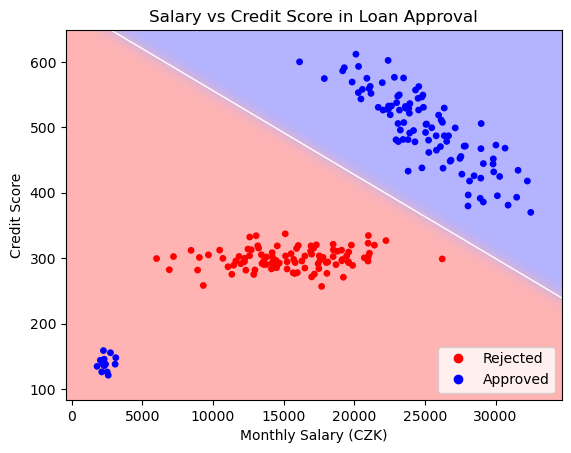

In [18]:
plot_decision_boundary(X_poisoned, y_poisoned, log_reg_model_poisoned, reveres_proba=True)

In [19]:
nn_model_poisoned = SimpleNN()
train(nn_model_poisoned, X_poisoned, y_poisoned)

Epochs: 100%|██████████| 300/300 [00:04<00:00, 62.24it/s]


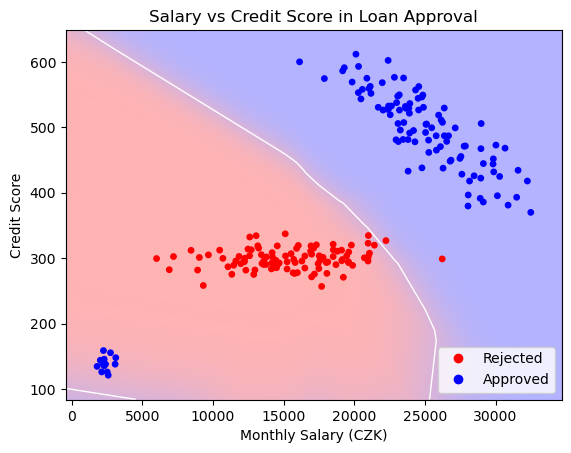

In [20]:
plot_decision_boundary(X_poisoned, y_poisoned, nn_model_poisoned)

![](images/ml_in_a_nutshell.png)